<a href="https://colab.research.google.com/github/tomonari-masada/course-nlp2020/blob/master/11_topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 標準使用ライブラリー
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc
import os
import shutil
from icecream import ic
from tqdm import tqdm_notebook as tqdm 

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 追記
import json
import datetime
import math
plt.style.use('dark_background')

# debug
#%pdb on

import pixiedust #%pixie_debugger

# tfがエラーはかないため
# tfがエラーはかないため
#import tensorflow as tf
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="5"
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)


Pixiedust database opened successfully


In [2]:
import pandas as pd
import re

df = pd.read_csv("./result0605_tweet.csv")

type(df["text"])
docs = df["text"].to_list()

In [3]:
print(len(docs))

151278


In [4]:
print(docs[0][:1000])

RT @rintaro_maro: 歴代興行収入1位記念🎉「鬼滅キャラがジブリの世界に行ったら」#鬼滅の刃無限列車編  #千と千尋 https://t.co/ZJWVE54rcn


### Neologdを使ってtokenizeする

In [5]:
import subprocess
cmd='echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
path_neologd = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
                           shell=True).communicate()[0]).decode('utf-8')
import MeCab
m=MeCab.Tagger("-Ochasen -d "+str(path_neologd))

def mecab_prep_text( text):
  items = (re.split('[\t,]', line) for line in m.parse(text).split('\n'))
    
  words = [item[0]
         for item in items
         if (item[0] not in ('EOS', '', 't', 'ー') and re.match( '名詞' ,item[3]  )
              )]
  return words

* tokenizationの実行

In [6]:
from tqdm import tqdm

new_docs = list()
for doc in tqdm(docs):
  new_docs.append( mecab_prep_text(doc) )

100%|██████████| 151278/151278 [01:25<00:00, 1766.36it/s]


* tokenizationの結果を確認

In [7]:
print(new_docs[0])

['RT', 'rintaro', 'maro', '歴代', '興行収入', '1位', '記念', '🎉', '鬼', '滅', 'キャラ', 'ジブリ', '世界', '鬼滅の刃', '無限', '列車', '編', '千と千尋', 'https', 'co', 'ZJWVE', '54', 'rcn']


* 各文書を長い文字列で表しなおす（CountVectorizerを後で使うため）

In [8]:
corpus = [' '.join(doc) for doc in new_docs]

In [9]:
corpus[0]

'RT rintaro maro 歴代 興行収入 1位 記念 🎉 鬼 滅 キャラ ジブリ 世界 鬼滅の刃 無限 列車 編 千と千尋 https co ZJWVE 54 rcn'

## 11-02 データ行列の作成
* NMFの場合、TF-IDFで単語の重みを求めて各文書をベクトル化する。
* LDAの場合、単に単語の出現頻度を重みとして各文書をベクトル化する。

### sklearnのCountVectorizerで疎行列化する

* 全文書の半分より多い文書に現れる単語は、高頻度語とみなして削除する。
* 10件未満の文書にしか現れない単語は、低頻度語とみなして削除する。

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.5, min_df=10, stop_words='english')
X = vectorizer.fit_transform(corpus)

In [11]:
print(X[0])

  (0, 3210)	1
  (0, 2579)	1
  (0, 8443)	1
  (0, 9251)	1
  (0, 349)	1
  (0, 9405)	1
  (0, 5254)	1
  (0, 5481)	1
  (0, 6507)	1
  (0, 7067)	1
  (0, 4135)	1
  (0, 772)	1
  (0, 3164)	1


In [12]:
print(vectorizer.get_feature_names())

['00', '000', '00212246', '003', '0058', '007', '0083', '009', '01', '0105', '0109', '0111', '0112', '0117', '012', '02', '0202', '02024814', '0205', '0209', '0215', '0218', '0221', '0222', '0241', '0259', '03', '0308', '0309', '0317', '0325', '0329', '035', '039', '04', '0406', '0409', '0410', '0419', '0421', '0426', '0430', '045', '046', '048', '05', '050', '0502', '0510', '0513', '0518', '0519', '051920', '0527', '05311', '06', '0614', '0616', '06171', '0619', '0620', '0626', '07', '0704', '0714', '08', '0802', '0806', '081', '0810', '0825', '0826', '0830', '09', '0901', '0903', '0910', '0913', '0919', '0920', '09257199', '0986', '0g', '0m', '0t', '0v', '0w', '0時', '10', '100', '1000', '10000人', '1000万', '1000万人', '1000人', '1000円', '1000回', '1001', '1004', '1005', '1008', '100パーセント', '100万', '100万人', '100万円', '100人', '100倍', '100億', '100億の男', '100億円', '100円', '100回', '100均', '100日', '100点', '101', '1010', '1014', '10144627', '1016', '10161105', '10164', '1017', '1020', '1023', '1025

In [13]:
print(len(vectorizer.get_feature_names()))

9970


* 文書数と語彙サイズを変数にセット

In [14]:
X.shape

(151278, 9970)

In [15]:
n_samples, n_features = X.shape

### TF-IDFで各文書における単語の重みを計算する

In [16]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()
Xtfidf = tfidf.fit_transform(X)

In [17]:
print(Xtfidf[0])

  (0, 9405)	0.24586688293613404
  (0, 9251)	0.21514060217631692
  (0, 8443)	0.22569156944186594
  (0, 7067)	0.28755486831772226
  (0, 6507)	0.29101007625607683
  (0, 5481)	0.29853212200927065
  (0, 5254)	0.2759152421501221
  (0, 4135)	0.30631039437181656
  (0, 3210)	0.3023858749185146
  (0, 3164)	0.30631039437181656
  (0, 2579)	0.3017081884504629
  (0, 772)	0.30497475086253517
  (0, 349)	0.21581296245370285


In [18]:
Xtfidf.shape

(151278, 9970)

* 抽出するトピックの個数は、今回は20個とする。

In [19]:
n_components = 20

## 11-03 NMFでトピック抽出
* まず、TF-IDFのデータ行列を使って　NMFによってトピック抽出を試みる。
 * NMFのパラメータ群は下記サンプルコードのまま。
 * https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

### NMFとLDAのインポート

In [20]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

### NMFによるトピック抽出の実行

In [21]:
from time import time

print((f"Fitting the NMF model (generalized Kullback-Leibler "
  f"divergence) with tf-idf features, n_samples={n_samples} "
  f"and n_features={n_features}"))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1, l1_ratio=.5,
          verbose=1)
nmf.fit(Xtfidf)
print(f"done in {time() - t0:0.3f}s.")

Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=151278 and n_features=9970
Epoch 10 reached after 7.068 seconds, error: 1728.843145
Epoch 20 reached after 13.599 seconds, error: 1726.023443
Epoch 30 reached after 20.130 seconds, error: 1725.205397
Epoch 40 reached after 26.694 seconds, error: 1724.890396
Epoch 50 reached after 33.247 seconds, error: 1724.705752
done in 36.313s.


* NMFにおける各コンポーネントは、それぞれのトピックにおける単語の重要度を表すベクトルとして表現されている。

In [22]:
nmf.components_

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 2.47346851e-02, ...,
        0.00000000e+00, 7.19453807e-05, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.79990622e-02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

### トピックの重要語を取り出す関数の定義

In [23]:
def get_top_words(model, feature_names, n_top_words=30):
  top_features = list()
  weights = list()
  for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features.append([feature_names[i] for i in top_features_ind])
    weights.append(topic[top_features_ind])
  return top_features, weights

### NMFの各コンポーネントから重要語を取り出す

In [24]:
top_words, weights = get_top_words(nmf, vectorizer.get_feature_names())

In [25]:
print(top_words[0])

['無惨', 'キリショー', '終了', '会議', '実写', 'youtube', 'gackt', 'パワハラ', 'パワハラ会議', '裏側', 'ptt', '格付けチェック', '格付け', 'qzobxg', 'milksalz', 'ir', '年初', 'scu', 'sca', 'saver', 'sc', 'sbm', 'say', 'sauce', 'sayoko', 'sayakaasura', 'sayaka', 'sb', 'sea', 'sd']


In [26]:
topic_words = [dict(zip(top_words[i], weights[i])) for i in range(n_components)]

In [27]:
topic_words[0]

{'無惨': 4.644121970535856,
 'キリショー': 4.631600454720821,
 '終了': 2.3767204261421435,
 '会議': 2.344426604750007,
 '実写': 2.3347297975455774,
 'youtube': 2.326557206999799,
 'gackt': 2.319655238039889,
 'パワハラ': 2.318921587059611,
 'パワハラ会議': 2.318735959426066,
 '裏側': 2.317614639449973,
 'ptt': 2.317511807158366,
 '格付けチェック': 2.3161744567773646,
 '格付け': 2.316138458563326,
 'qzobxg': 2.316064386121329,
 'milksalz': 2.3160270257673243,
 'ir': 0.0006581047259144552,
 '年初': 8.983131287665574e-16,
 'scu': 0.0,
 'sca': 0.0,
 'saver': 0.0,
 'sc': 0.0,
 'sbm': 0.0,
 'say': 0.0,
 'sauce': 0.0,
 'sayoko': 0.0,
 'sayakaasura': 0.0,
 'sayaka': 0.0,
 'sb': 0.0,
 'sea': 0.0,
 'sd': 0.0}

### 重要語をワードクラウドで可視化

In [28]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS

* ワードクラウドから除去するストップワードを確認する。

In [29]:
print(STOPWORDS)

{"they've", 'ours', 'as', 'when', 'however', "mustn't", "doesn't", 'again', 'r', 'been', "haven't", 'could', 'each', "when's", 'get', 'very', 'what', 'there', 'where', 'most', 'on', 'before', 'after', 'few', "shan't", 'too', 'are', 'you', 'in', "they'll", 'hers', "you'd", "wasn't", 'ought', "couldn't", "aren't", 'to', 'because', 'does', "i've", 'nor', "we've", 'they', "weren't", "why's", 'like', "who's", 'during', 'your', 'had', 'http', "she'd", 'the', 'themselves', 'being', 'theirs', "here's", 'my', 'should', 'once', 'more', 'that', "he'd", 'not', 'who', 'be', "there's", 'would', 'through', 'www', 'k', "you're", 'about', "isn't", "you'll", 'therefore', "didn't", "what's", 'how', 'and', 'out', 'any', 'at', 'a', 'their', 'have', "it's", "that's", 'she', 'until', 'i', 'further', 'or', "he's", "you've", 'its', 'yours', 'me', "they'd", "they're", 'no', 'whom', 'with', "shouldn't", 'between', 'doing', "let's", 'we', 'why', 'else', 'were', 'some', 'do', "she's", "won't", 'her', "hasn't", 'ov

* ワードクラウドを描画

In [30]:
FONT_PATH = "/usr/share/fonts/opentype/ipaexfont-mincho/ipaexm.ttf"
cloud = WordCloud(stopwords=STOPWORDS,
                  font_path=FONT_PATH,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab10'
                  )

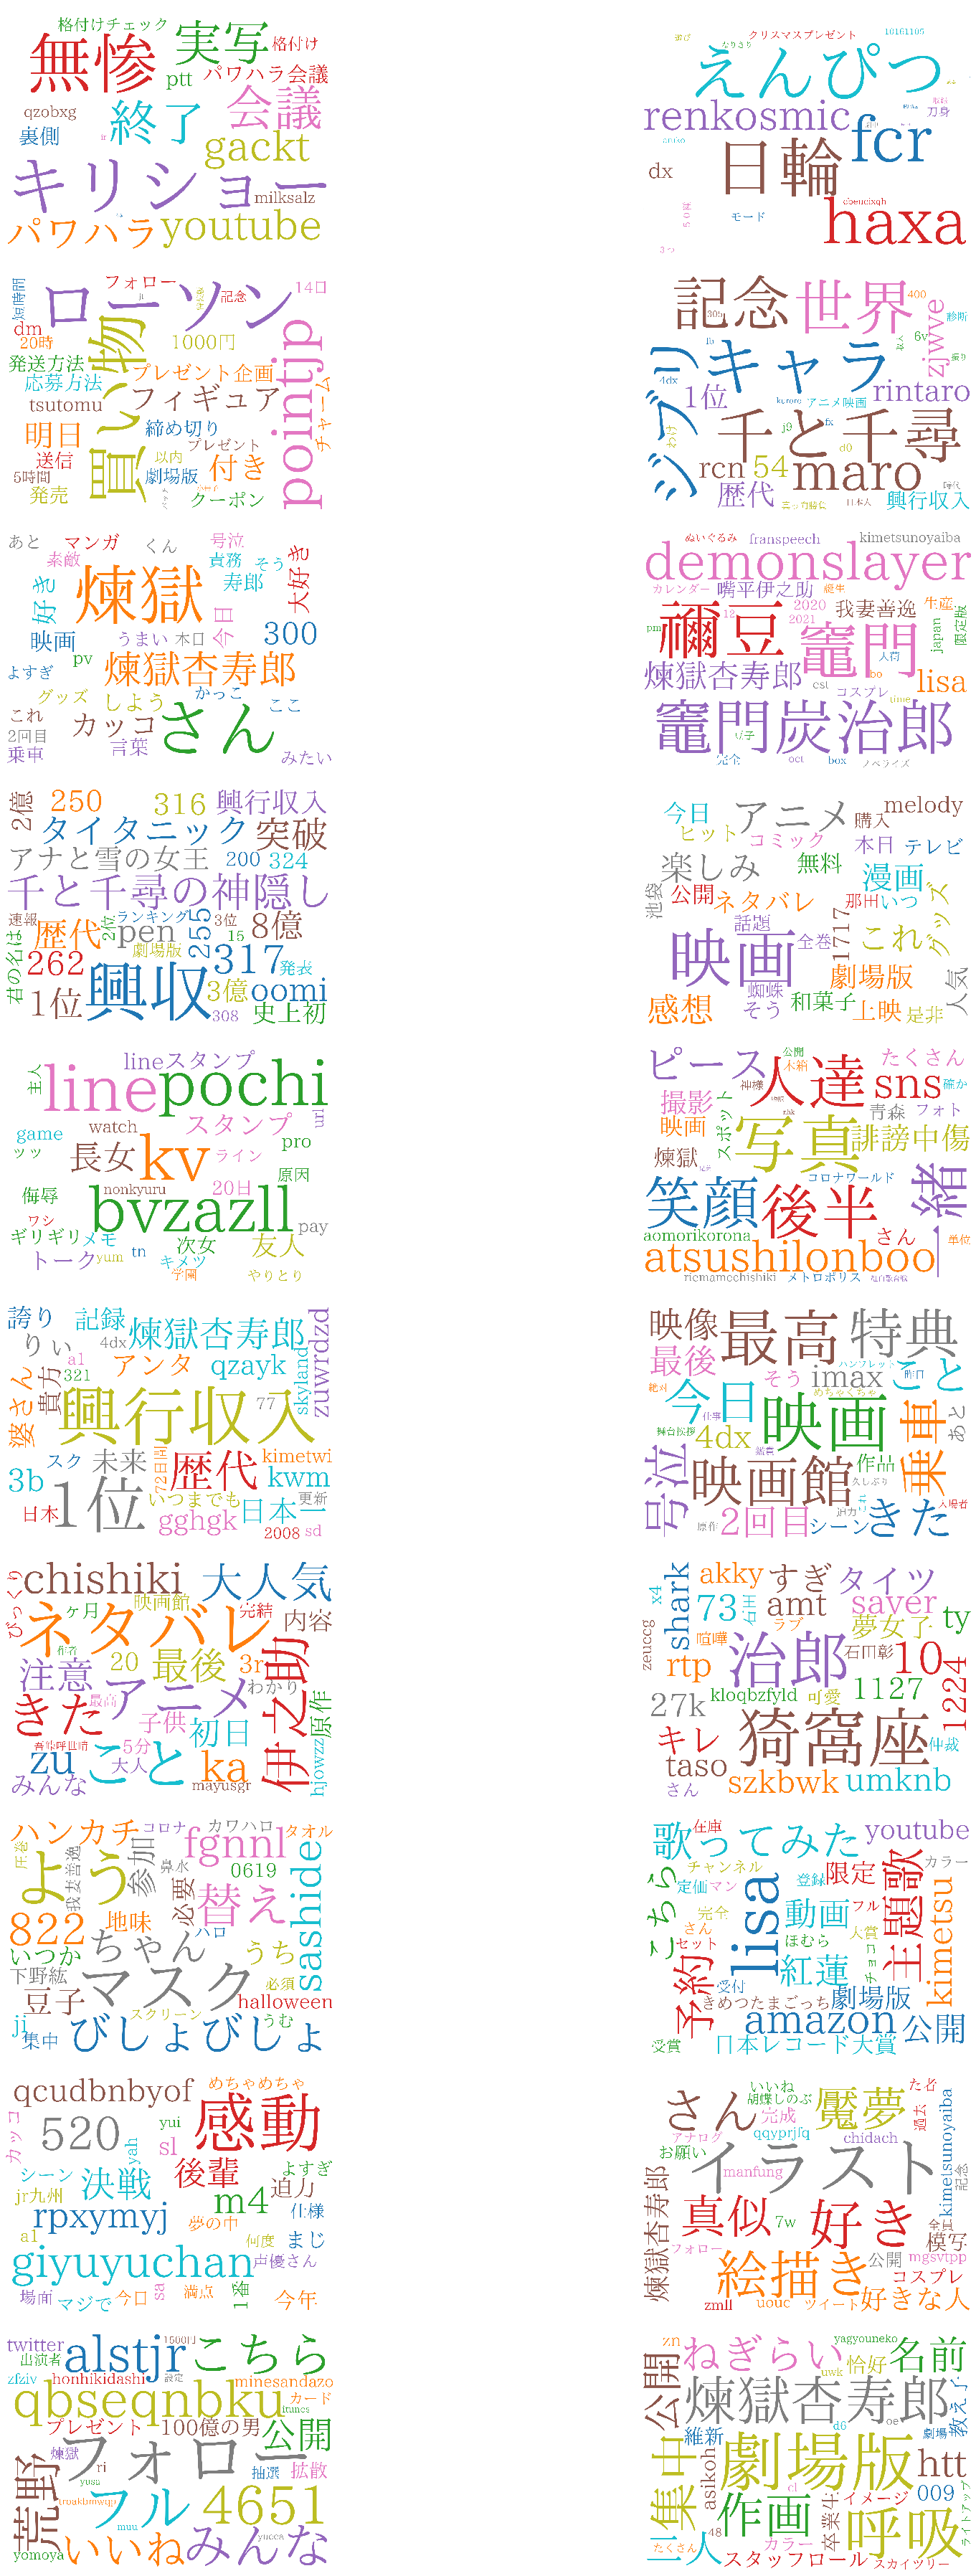

In [31]:
fig, axes = plt.subplots(10, 2, figsize=(32, 50), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
  fig.add_subplot(ax)
  cloud.generate_from_frequencies(topic_words[i], max_font_size=500)
  plt.gca().imshow(cloud)
  plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
  plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()

## 11-04 LDAでトピック抽出

### LDAによるトピック抽出の実行

In [32]:
lda = LatentDirichletAllocation(n_components=n_components, 
                                max_iter=20,
                                topic_word_prior=0.01,
                                learning_method='online',
                                learning_offset=50,
                                batch_size=200,
                                mean_change_tol=1e-4,
                                random_state=1,
                                evaluate_every=1,
                                verbose=1)

In [33]:
print((f"Fitting LDA models with tf features, "
  f"n_samples={n_samples} and n_features={n_features}"))
t0 = time()
lda.fit(X)
print(f"done in {time() - t0:0.3f}s.")

Fitting LDA models with tf features, n_samples=151278 and n_features=9970
iteration: 1 of max_iter: 20, perplexity: 3078025721.9449
iteration: 2 of max_iter: 20, perplexity: 2743269973.6690
iteration: 3 of max_iter: 20, perplexity: 2583340892.4066
iteration: 4 of max_iter: 20, perplexity: 2513800340.5679
iteration: 5 of max_iter: 20, perplexity: 2475525758.1560
iteration: 6 of max_iter: 20, perplexity: 2451351214.7752
iteration: 7 of max_iter: 20, perplexity: 2435222606.0627
iteration: 8 of max_iter: 20, perplexity: 2423603525.5354
iteration: 9 of max_iter: 20, perplexity: 2414086215.6544
iteration: 10 of max_iter: 20, perplexity: 2406384886.5122
iteration: 11 of max_iter: 20, perplexity: 2401003827.9305
iteration: 12 of max_iter: 20, perplexity: 2396145583.7602
iteration: 13 of max_iter: 20, perplexity: 2392209787.5939
iteration: 14 of max_iter: 20, perplexity: 2389156446.5331
iteration: 15 of max_iter: 20, perplexity: 2386599994.2818
iteration: 16 of max_iter: 20, perplexity: 2382233

### LDAの各トピックから高確率語を取り出す

In [34]:
top_words, weights = get_top_words(lda, vectorizer.get_feature_names())

In [35]:
print(top_words[0])

['禰豆', '竈門', '竈門炭治郎', '映画', '今日', '号泣', '乗車', 'demonslayer', '2回目', 'imax', '今回', '鑑賞', '治郎', 'ツイート', '映画館', '仕事', 'フォロワー', '荒野', 'mx4d', '嘴平伊之助', 'twitter', 'スクリーン', '気持ち', '昨日', 'お願い', '1回', '全部', '3回目', '今年', 'よすぎ']


In [36]:
topic_words = [dict(zip(top_words[i], weights[i])) for i in range(n_components)]

### 高確率語をワードクラウドで可視化

In [37]:
cloud = WordCloud(stopwords=STOPWORDS,
                                font_path=FONT_PATH,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab10'
                  )

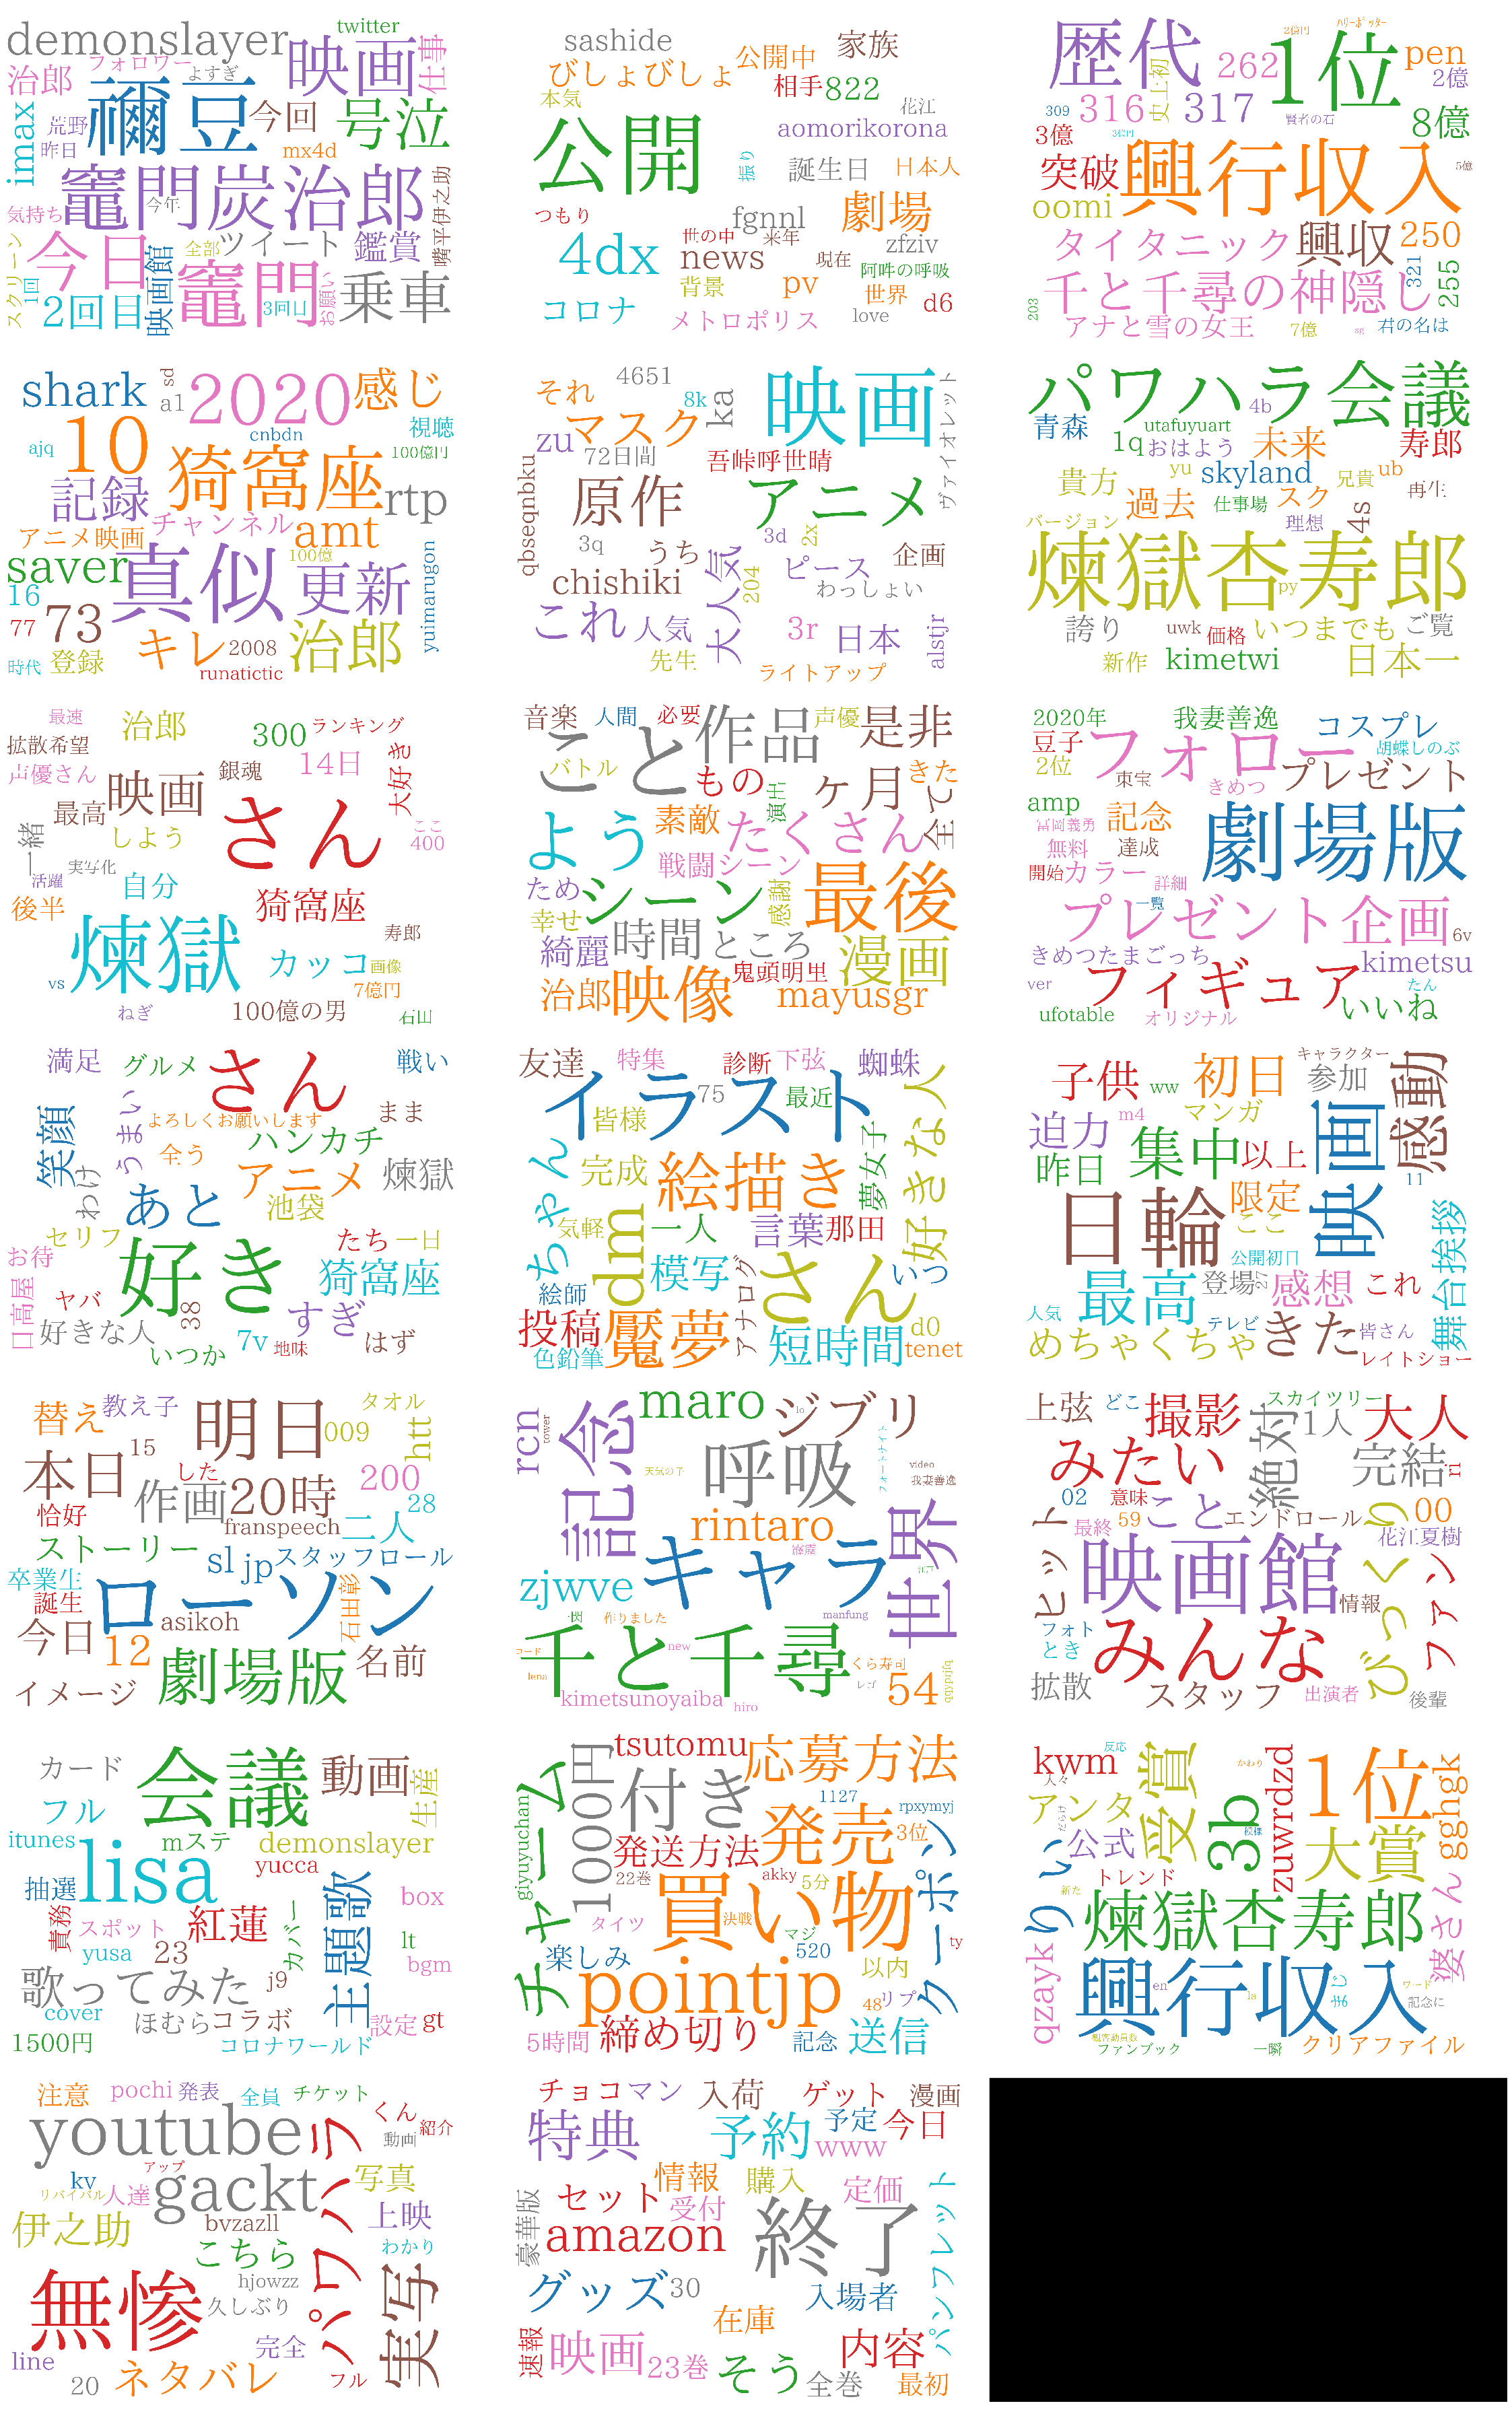

In [38]:
# fig, axes = plt.subplots(5, 4, figsize=(16, 25), sharex=True, sharey=True)
fig, axes = plt.subplots(7, 3, figsize=(32, 50), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    
  if i > len(topic_words)-1:
    break

  fig.add_subplot(ax)
  cloud.generate_from_frequencies(topic_words[i], max_font_size=500)
  plt.gca().imshow(cloud)
  plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
  plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()


from matplotlib.backends.backend_pdf import PdfPages

import datetime
pdf = PdfPages( 
(datetime.datetime.now() + datetime.timedelta(hours=9) ) .strftime('%m%d_%H%M') + 'topic.pdf')


fignums = plt.get_fignums()
for fignum in fignums:
    plt.figure(fignum)
    pdf.savefig()

pdf.close()

In [39]:
# !pip install pyLDAvis

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [40]:
import pyLDAvis
import pyLDAvis.sklearn

In [41]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, X, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
18     -10.878068   10.538728       1        1  9.507385
6      -60.884026  -75.591820       2        1  8.805838
19      -2.336119  -53.289074       3        1  6.679823
11     -61.385319  -12.914634       4        1  6.335023
0      -28.737743  126.296997       5        1  6.165937
8        1.066606 -123.552811       6        1  5.935842
16      45.140720   -7.947869       7        1  5.926018
15    -140.795975  -98.530548       8        1  5.561875
2       61.531681  -83.240562       9        1  5.366565
12     -72.563057 -140.396881      10        1  5.038902
7       15.984491   63.578186      11        1  4.792077
10    -160.851624   68.945145      12        1  4.385743
14      85.961830   51.922935      13        1  4.374354
9      -99.020836  109.936348      14        1  4.033824
4     -176.764130   -8.681684      15        1  3.881829
5     -117.189880  -37.420200      16        1  3.452135
13     108.829918  -22.946203      17        1  3.321225
1       47.588097  121.934814      18        1  2.523977
3     -106.467834   30.176889      19        1  2.419390
17     -50.613804   59.328842      20        1  1.492238, topic_info=       Term          Freq         Total Category  logprob  loglift
4537     さん  53625.000000  53625.000000  Default  30.0000  30.0000
8660     煉獄  39511.000000  39511.000000  Default  29.0000  29.0000
8641     無惨  32885.000000  32885.000000  Default  28.0000  28.0000
8663  煉獄杏寿郎  24148.000000  24148.000000  Default  27.0000  27.0000
349      1位  21252.000000  21252.000000  Default  26.0000  26.0000
...     ...           ...           ...      ...      ...      ...
2111     im     90.193822     90.421310  Topic20  -5.6356   4.2024
1521   dfhx     85.392127     85.619615  Topic20  -5.6903   4.2022
9251   興行収入   2577.447763  20400.826984  Topic20  -2.2830   2.1361
349      1位   2299.555977  21252.517200  Topic20  -2.3971   1.9811
8663  煉獄杏寿郎   1442.449628  24148.209364  Topic20  -2.8635   1.3870

[720 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0        13  0.999270        00
7        10  0.999371       009
15       13  0.999519        02
62        5  1.000103        07
88       19  1.000079        10
...     ...       ...       ...
9777     11  0.999872        音楽
9782     11  0.998904        音響
9863     11  0.999415      鬼頭明里
9870     12  1.000061        魘夢
9962      9  0.998776  ﾊﾘｰﾎﾟｯﾀｰ

[717 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 7, 20, 12, 1, 9, 17, 16, 3, 13, 8, 11, 15, 10, 5, 6, 14, 2, 4, 18])